In [33]:
import pandas as pd

# Teams → city
LONDON_TEAMS = [
    'Arsenal', 'Chelsea', 'Crystal Palace',
    'Fulham', 'Tottenham Hotspur', 'West Ham United'
]
MANCHESTER_TEAMS = ['Man City', 'Man United']

def city_of(team):
    if team in LONDON_TEAMS:
        return 'London'
    if team in MANCHESTER_TEAMS:
        return 'Manchester'
    return 'Other'

def classify_precip(mm):
    if pd.isna(mm) or mm == 0:
        return 'Clear'
    elif mm <= 1:
        return 'Light'
    elif mm <= 3:
        return 'Moderate'
    else:
        return 'Heavy'

def time_of_day(hour):
    return 'Afternoon' if hour < 17 else 'Evening'

seasons = [
    {'label':'2000-2001','prem':'Prem 2000-2001.csv',
     'wl':'London Weather 2000-2001.csv','wm':'Manchester Weather 2000-2001.csv','fmt':'%d/%m/%y'},
    {'label':'2001-2002','prem':'Prem 2001-2002.csv',
     'wl':'London Weather 2001-2002.csv','wm':'Manchester Weather 2001-2002.csv','fmt':'%d/%m/%y'},
    {'label':'2020-2021','prem':'Prem 2020-2021.csv',
     'wl':'London Weather 2020-2021.csv','wm':'Manchester Weather 2020-2021.csv','fmt':'%d/%m/%Y'},
    {'label':'2021-2022','prem':'Prem 2021-2022.csv',
     'wl':'London Weather 2021-2022.csv','wm':'Manchester Weather 2021-2022.csv','fmt':'%d/%m/%Y'}
]

for s in seasons:
    # load matches
    m = pd.read_csv(s['prem'])
    m['Date'] = pd.to_datetime(m['Date'],format=s['fmt'],dayfirst=True)
    m['City'] = m['HomeTeam'].apply(city_of)
    m = m[m['City'].isin(['London','Manchester'])]

    # load weather
    lw = pd.read_csv(s['wl']); lw['Date']=pd.to_datetime(lw['datetime'])
    mw = pd.read_csv(s['wm']); mw['Date']=pd.to_datetime(mw['datetime'])

    # merge
    lon = pd.merge(m[m['City']=='London'], lw, on='Date', how='left')
    man = pd.merge(m[m['City']=='Manchester'], mw, on='Date', how='left')
    df = pd.concat([lon, man], ignore_index=True)

    # compute & clean
    df['TotalGoals'] = df['FTHG']+df['FTAG']
    df = df.dropna(subset=['temp','precip'])
    df['PrecipBin'] = df['precip'].apply(classify_precip)
    if 'Attendance' in df: df['Attendance']=pd.to_numeric(df['Attendance'],errors='coerce')
    if 'Time' in df:
        times = pd.to_datetime(df['Time'],format='%H:%M',errors='coerce')
        df['Hour'] = times.dt.hour
        df['TimeBin'] = df['Hour'].apply(time_of_day)
    df['Season']=s['label']

    cols = ['Date','Season','City','Referee','TotalGoals','temp','precip','PrecipBin','preciptype']
    if 'Attendance' in df: cols.append('Attendance')
    if 'TimeBin' in df:    cols.append('TimeBin')
    clean = df[cols]

    filename = f"cleaned_{s['label']}.csv"
    clean.to_csv(filename,index=False)
    print(f"→ saved {filename} ({len(clean)} rows)")


→ saved cleaned_2000-2001.csv (76 rows)
→ saved cleaned_2001-2002.csv (76 rows)
→ saved cleaned_2020-2021.csv (114 rows)
→ saved cleaned_2021-2022.csv (95 rows)


# Premier League Goals – EDA, Hypothesis Tests & ML
**Author:** [Your Name]  
**Repo:** https://github.com/MazenZeybek/DSA210-SPRING-PROJECT  


In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import pearsonr, ttest_ind


In [35]:
## 1. Load cleaned data


In [36]:
seasons = ['2000-2001','2001-2002','2020-2021','2021-2022']
df_list = []
for s in seasons:
    df = pd.read_csv(f"cleaned_{s}.csv", parse_dates=['Date'])
    df_list.append(df)
data = pd.concat(df_list, ignore_index=True)


In [37]:
## 2. Goals Distribution per Season


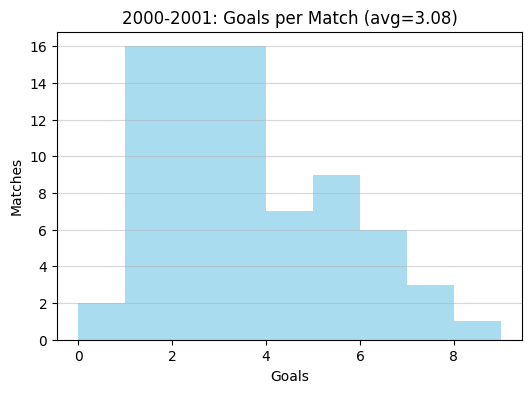

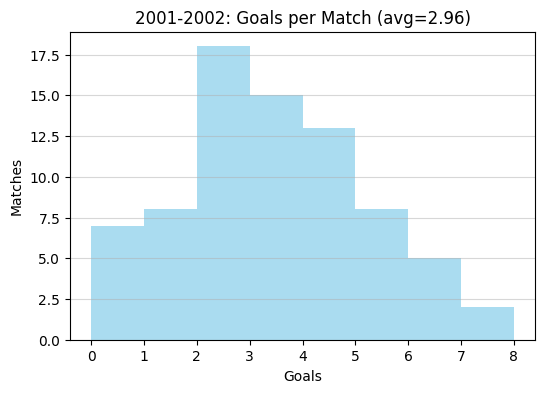

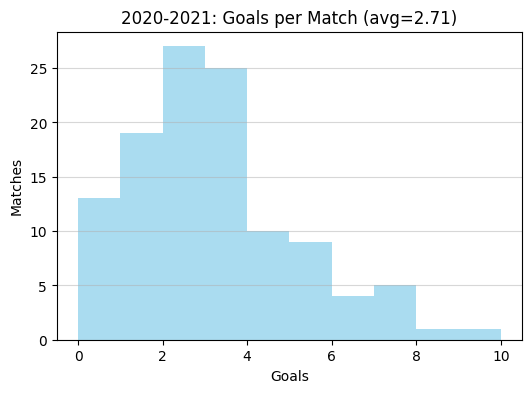

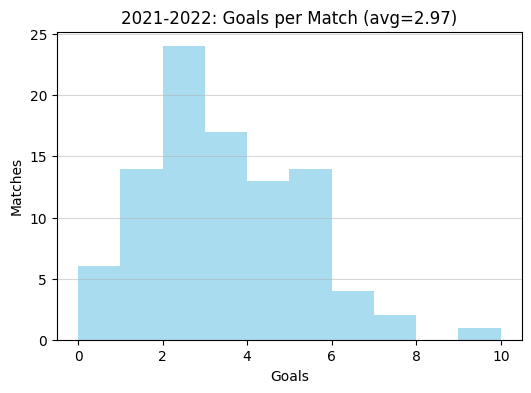

In [38]:
for s in seasons:
    sub = data[data['Season']==s]
    avg_g = sub['TotalGoals'].mean()

    # compute integer max + 2 for bins
    max_goals = int(sub['TotalGoals'].max()) + 2

    plt.figure(figsize=(6,4))
    plt.hist(
        sub['TotalGoals'],
        bins=range(0, max_goals),
        color='skyblue',
        alpha=0.7
    )
    plt.title(f"{s}: Goals per Match (avg={avg_g:.2f})")
    plt.xlabel("Goals")
    plt.ylabel("Matches")
    plt.grid(axis='y', alpha=0.5)
    plt.show()


In [39]:
## 3. Weather Impact


Precipitation counts & avg goals:
preciptype
rain    248
None     87
snow     26
Name: count, dtype: int64 
 preciptype
None    2.92
rain    2.84
snow    3.54
Name: TotalGoals, dtype: float64 



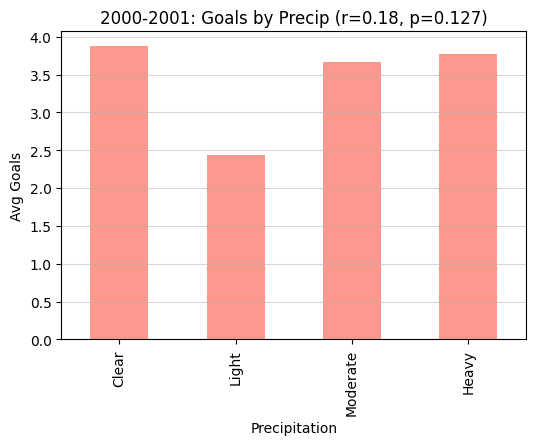

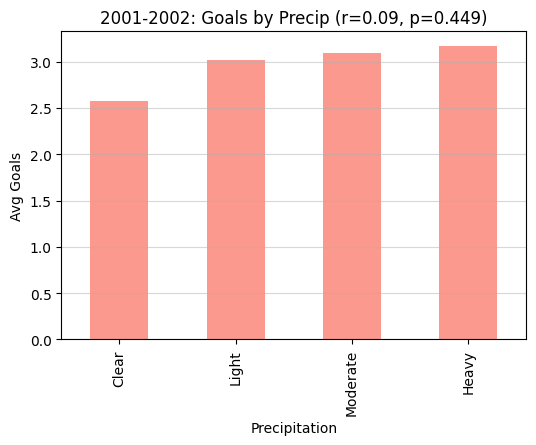

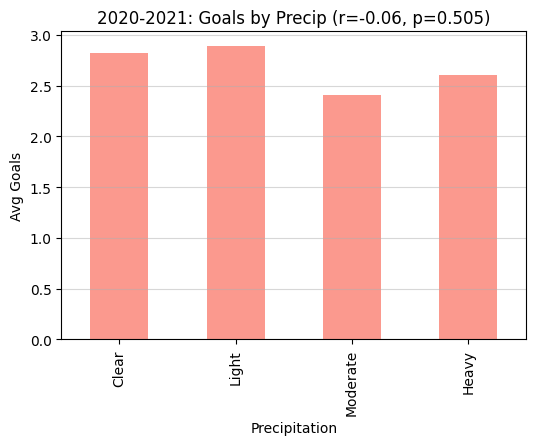

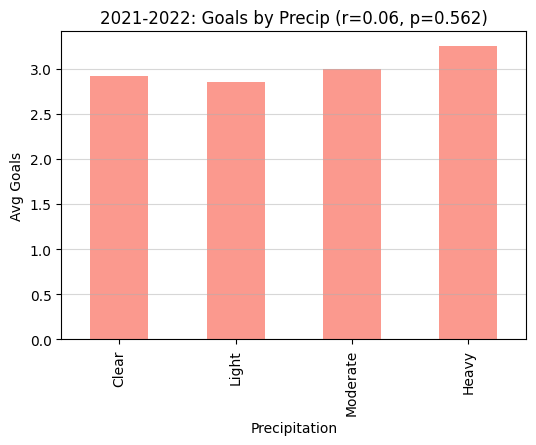

In [40]:
print("Precipitation counts & avg goals:")
cnts = data['preciptype'].fillna('None').value_counts()
avgs = data.groupby(data['preciptype'].fillna('None'))['TotalGoals']\
           .mean().round(2)
print(cnts, "\n", avgs, "\n")

for s in seasons:
    sub = data[data['Season']==s]
    mean_goals = sub.groupby('PrecipBin')['TotalGoals']\
                    .mean().reindex(['Clear','Light','Moderate','Heavy'])
    r,p = pearsonr(sub['PrecipBin']
                   .map({'Clear':0,'Light':1,'Moderate':2,'Heavy':3}),
                   sub['TotalGoals'])
    plt.figure(figsize=(6,4))
    mean_goals.plot(kind='bar', color='salmon', alpha=0.8)
    plt.title(f"{s}: Goals by Precip (r={r:.2f}, p={p:.3f})")
    plt.ylabel("Avg Goals"); plt.xlabel("Precipitation")
    plt.grid(axis='y', alpha=0.5)
    plt.show()


In [41]:
## 4. Temperature vs Goals


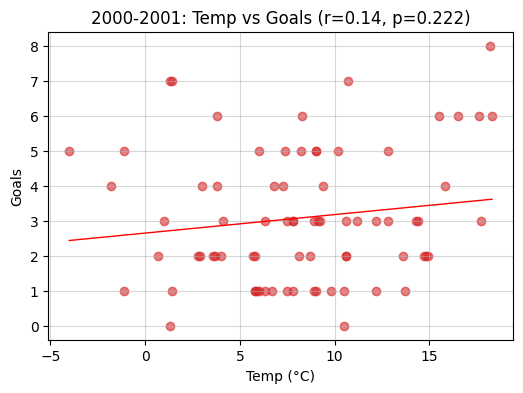

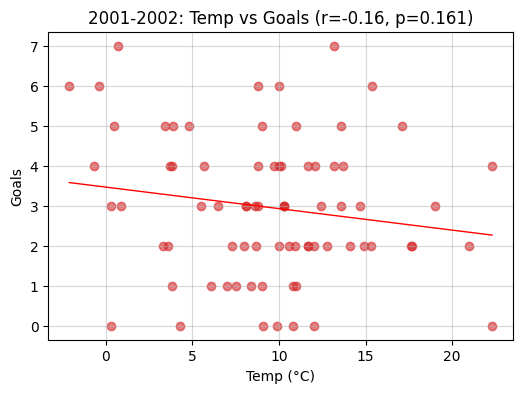

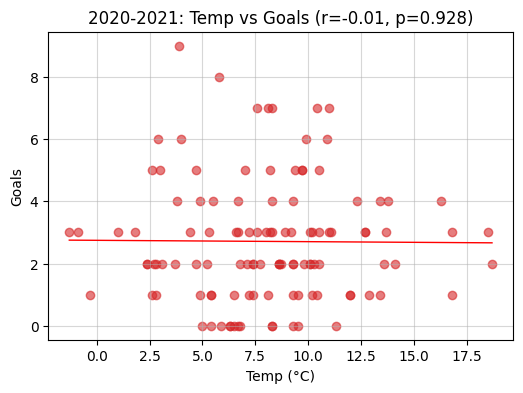

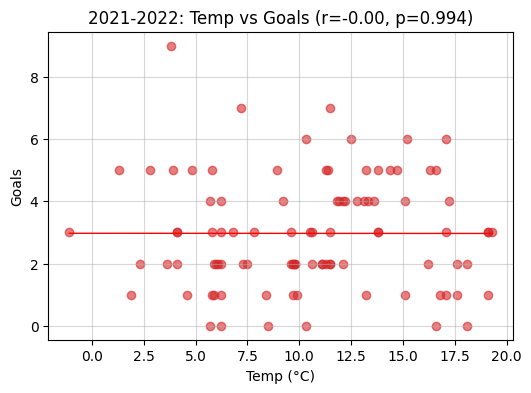

In [42]:
for s in seasons:
    sub = data[data['Season']==s]
    r,p = pearsonr(sub['temp'], sub['TotalGoals'])
    plt.figure(figsize=(6,4))
    plt.scatter(sub['temp'], sub['TotalGoals'], color='C3', alpha=0.6)
    m,b = np.polyfit(sub['temp'], sub['TotalGoals'], 1)
    xs = np.linspace(sub['temp'].min(), sub['temp'].max(), 100)
    plt.plot(xs, m*xs+b, color='red', lw=1)
    plt.title(f"{s}: Temp vs Goals (r={r:.2f}, p={p:.3f})")
    plt.xlabel("Temp (°C)"); plt.ylabel("Goals")
    plt.grid(alpha=0.5)
    plt.show()


In [43]:
## 5. Attendance Influence


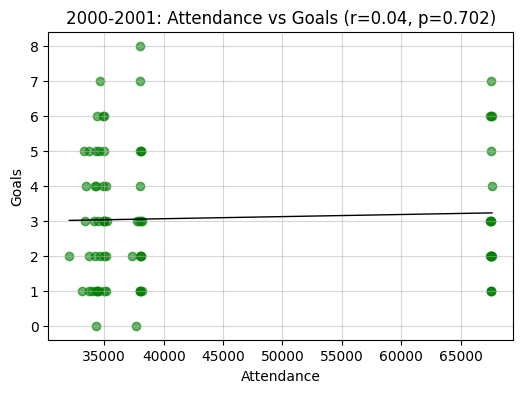

<ipython-input-44-e6daef4ea401>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp['Attendance'] = pd.to_numeric(tmp['Attendance'], errors='coerce')


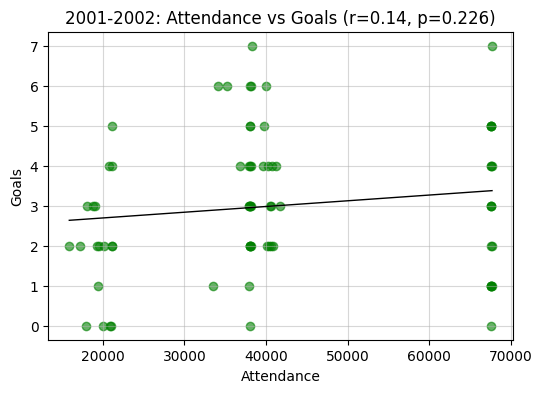

2020-2021: insufficient attendance data
2021-2022: insufficient attendance data


In [44]:
for s in seasons:
    sub = data[data['Season']==s]
    if 'Attendance' not in sub: continue
    tmp = sub.dropna(subset=['Attendance','TotalGoals'])
    tmp['Attendance'] = pd.to_numeric(tmp['Attendance'], errors='coerce')
    if len(tmp)<2:
        print(f"{s}: insufficient attendance data")
        continue
    r,p = pearsonr(tmp['Attendance'], tmp['TotalGoals'])
    plt.figure(figsize=(6,4))
    plt.scatter(tmp['Attendance'], tmp['TotalGoals'],
                color='green', alpha=0.6)
    m,b = np.polyfit(tmp['Attendance'], tmp['TotalGoals'], 1)
    xs = np.linspace(tmp['Attendance'].min(), tmp['Attendance'].max(), 100)
    plt.plot(xs, m*xs+b, color='black', lw=1)
    plt.title(f"{s}: Attendance vs Goals (r={r:.2f}, p={p:.3f})")
    plt.xlabel("Attendance"); plt.ylabel("Goals")
    plt.grid(alpha=0.5)
    plt.show()


In [45]:
## 6. VAR Era Comparison


Pre-VAR avg=3.02, Post-VAR avg=2.83
t=-0.97, p=0.332


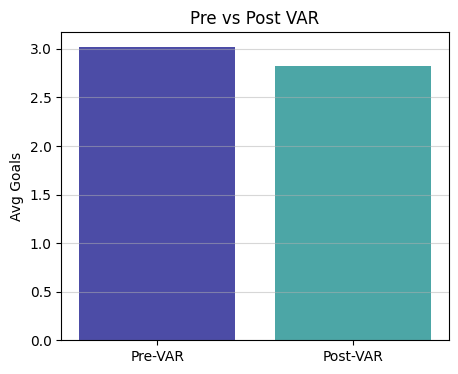

In [46]:
pre = data[data['Season'].isin(['2000-2001','2001-2002'])]['TotalGoals']
post= data[data['Season'].isin(['2020-2021','2021-2022'])]['TotalGoals']
t,p = ttest_ind(post, pre, equal_var=False)
print(f"Pre-VAR avg={pre.mean():.2f}, Post-VAR avg={post.mean():.2f}")
print(f"t={t:.2f}, p={p:.3f}")
plt.figure(figsize=(5,4))
plt.bar(['Pre-VAR','Post-VAR'], [pre.mean(), post.mean()],
        color=['navy','teal'], alpha=0.7)
plt.title("Pre vs Post VAR"); plt.ylabel("Avg Goals")
plt.grid(axis='y', alpha=0.5)
plt.show()


In [47]:
## 7. Time-of-Day Analysis (Afternoon vs Evening)


               mean  count
TimeBin                   
Afternoon  2.982456    114
Evening    2.642105     95


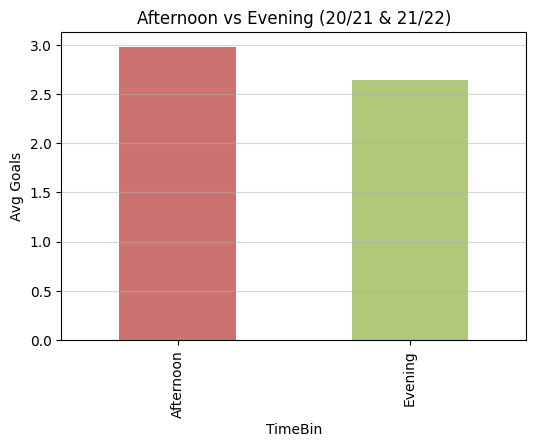

In [48]:
recent = data[data['Season'].isin(['2020-2021','2021-2022'])]
if 'TimeBin' in recent:
    grp = recent[recent['TimeBin'].isin(['Afternoon','Evening'])]
    stats = grp.groupby('TimeBin')['TotalGoals'].agg(['mean','count'])
    print(stats)
    plt.figure(figsize=(6,4))
    stats['mean'].plot(kind='bar',
                       color=['#C0504D','#9BBB59'], alpha=0.8)
    plt.title("Afternoon vs Evening (20/21 & 21/22)")
    plt.ylabel("Avg Goals"); plt.grid(axis='y', alpha=0.5)
    plt.show()


In [49]:
## 8. Hypothesis Test: Heavy vs Clear Rain


In [50]:
heavy = data[data['PrecipBin']=='Heavy']['TotalGoals']
clear = data[data['PrecipBin']=='Clear']['TotalGoals']
t,p = ttest_ind(heavy, clear, equal_var=False)
print(f"Heavy (n={len(heavy)}): avg={heavy.mean():.2f}")
print(f"Clear (n={len(clear)}): avg={clear.mean():.2f}")
print(f"t={t:.2f}, p={p:.3f} →",
      "reject H0" if p<0.05 else "fail to reject H0")


Heavy (n=67): avg=3.10
Clear (n=87): avg=2.92
t=0.54, p=0.589 → fail to reject H0


In [51]:
## 9. Referee Impact


                mean  count
Referee                    
J Moss      2.956522     23
M Oliver    3.095238     21
A Taylor    3.941176     17
S Attwell   2.687500     16
M Atkinson  2.285714     14
D Coote     2.285714     14
A Marriner  2.076923     13
M Dean      2.666667     12
C Kavanagh  3.545455     11
P Tierney   3.090909     11


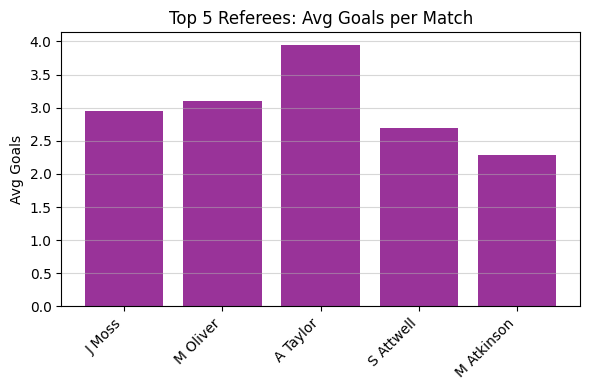

In [52]:
ref_counts = data['Referee'].value_counts()
eligible = ref_counts[ref_counts>=10].index
tab = (data[data['Referee'].isin(eligible)]
       .groupby('Referee')['TotalGoals']
       .agg(['mean','count'])
       .sort_values('count',ascending=False))
print(tab)

top5 = tab.head(5)
plt.figure(figsize=(6,4))
plt.bar(top5.index, top5['mean'], color='purple', alpha=0.8)
plt.title("Top 5 Referees: Avg Goals per Match")
plt.ylabel("Avg Goals")
plt.xticks(rotation=45,ha='right'); plt.grid(axis='y',alpha=0.5)
plt.tight_layout()
plt.show()


## 10. Machine Learning: Predict Over-2.5 Goals

We’ll turn `TotalGoals > 2.5` into a binary target and train a logistic regression.


In [53]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score

# Feature engineering
X = data[['temp','Attendance']].copy()
X['PrecipOrd'] = data['PrecipBin'].map({'Clear':0,'Light':1,'Moderate':2,'Heavy':3})
X['IsEvening'] = (data.get('TimeBin')=='Evening').astype(int)
X['Month']     = data['Date'].dt.month
y = (data['TotalGoals']>2.5).astype(int)

# Drop rows with missing features
mask = X.notnull().all(axis=1)
X, y = X[mask], y[mask]

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

# Fit & evaluate
clf = LogisticRegression(max_iter=1000)
clf.fit(X_train, y_train)
pred = clf.predict(X_test)

print(classification_report(y_test, pred))
print("ROC AUC:", roc_auc_score(y_test, clf.predict_proba(X_test)[:,1]))


              precision    recall  f1-score   support

           0       0.67      0.17      0.28        23
           1       0.53      0.91      0.67        23

    accuracy                           0.54        46
   macro avg       0.60      0.54      0.47        46
weighted avg       0.60      0.54      0.47        46

ROC AUC: 0.5633270321361058
